In [1]:
import torch
from torch_geometric.nn import summary
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt
import seaborn as sns
from adagrad import AdaGrad
from model import GCN
from torch_geometric.transforms import NormalizeFeatures
import time
import os

### Load Dataset

In [2]:
cwd = os.getcwd()
dataset = Planetoid(root=f'{cwd}/Datasets/', name='CiteSeer', transform=NormalizeFeatures())
data = dataset[0]

In [3]:
# Get some basic info about the dataset
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(50*'=')

# There is only one graph in the dataset, use it as new data object
data = dataset[0]  

# Gather some statistics about the graph.
print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Number of validation nodes: {data.val_mask.sum()}')
print(f'Number of testing nodes: {data.test_mask.sum()}')
print(f'Is undirected: {data.is_undirected()}')

Number of graphs: 1
Number of features: 3703
Number of classes: 6
Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])
Number of nodes: 3327
Number of edges: 9104
Number of training nodes: 120
Training node label rate: 0.04
Number of validation nodes: 500
Number of testing nodes: 1000
Is undirected: True


### Define your model

In [4]:
adagrad_model = GCN(in_channels=dataset.num_node_features,
                    hidden_channels=32,
                    out_channels=dataset.num_classes)
adagrad_optim = AdaGrad(adagrad_model.parameters(), lr = 0.01)

print(summary(adagrad_model, data.x, data.edge_index))

+------------------+-------------------------+----------------+----------+
| Layer            | Input Shape             | Output Shape   | #Param   |
|------------------+-------------------------+----------------+----------|
| GCN              | [3327, 3703], [2, 9104] | [3327, 6]      | 118,726  |
| ├─(conv1)GCNConv | [3327, 3703], [2, 9104] | [3327, 32]     | 118,528  |
| ├─(conv2)GCNConv | [3327, 32], [2, 9104]   | [3327, 6]      | 198      |
+------------------+-------------------------+----------------+----------+


In [5]:
adam_model = GCN(in_channels=dataset.num_node_features,
                 hidden_channels=32,
                 out_channels=dataset.num_classes)
adam_optim = torch.optim.Adam(adam_model.parameters(), lr=0.01, weight_decay=5e-4)

### Train and Testing functions

In [6]:
def train(model, optim):
    model.train()
    optim.zero_grad() 
    # Use all data as input, because all nodes have node features
    out = model(data.x, data.edge_index)
    print(out.shape)  
    # Only use nodes with labels available for loss calculation --> mask
    loss = torch.nn.functional.cross_entropy(out[data.train_mask], data.y[data.train_mask])  
    loss.backward() 
    optim.step()
    acc = test(model, data.train_mask)
    return loss.item(), acc

def eval(model):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        loss = torch.nn.functional.cross_entropy(out[data.val_mask], data.y[data.val_mask])
    
    acc = test(model, data.val_mask)
    return loss.item(), acc

def test(model, mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        # Use the class with highest probability.
        pred = out.argmax(dim=1)  
        # Check against ground-truth labels.
        test_correct = pred[mask] == data.y[mask]  
        # Derive ratio of correct predictions.
        acc = int(test_correct.sum()) / int(mask.sum())

        return acc

### Generate Plots function

In [7]:
def line_plot(train, val, label):
    plt.figure(figsize=(8, 8))
    sns.lineplot(x=range(len(train)), y=train, label=f"Train {label}")
    sns.lineplot(x=range(len(val)), y=val, label=f"Val {label}")
    plt.xlabel("Epoch")
    plt.ylabel(label)
    plt.legend()
    plt.title(f"Train and Val {label}")
    plt.show()

def bar_plot(model1_acc, model2_acc, y_label, title):
    data = {
        'Model': ['GCN_Adagrad', 'GCN_Adam'],
        y_label : [model1_acc, model2_acc]
    }
    
    plt.figure(figsize=(8,6))
    sns.barplot(data=data, x='Model', y=y_label, palette='Blues')
    plt.title(title)
    plt.show()

### Train with AdaGrad

In [8]:
adagrad_train_losses = []
adagrad_train_accuracies = []
adagrad_val_losses = []
adagrad_val_accuracies = []
for epoch in range(0, 30):
    train_loss, train_acc = train(adagrad_model, adagrad_optim)
    adagrad_train_losses.append(train_loss)
    adagrad_train_accuracies.append(train_acc)

    val_loss, val_acc = eval(adagrad_model)
    adagrad_val_losses.append(val_loss)
    adagrad_val_accuracies.append(val_acc)
    print(f'Epoch: {epoch:03d} -> Train Loss: {train_loss:.6f} Train Acc: {train_acc * 100:.2f}% Val Loss: {val_loss:.6f} Val Acc: {val_acc * 100:.2f}%')

torch.Size([3327, 6])
Epoch: 000 -> Train Loss: 1.791534 Train Acc: 50.83% Val Loss: 1.790295 Val Acc: 21.40%
torch.Size([3327, 6])
Epoch: 001 -> Train Loss: 1.782108 Train Acc: 80.00% Val Loss: 1.785547 Val Acc: 38.00%
torch.Size([3327, 6])
Epoch: 002 -> Train Loss: 1.770780 Train Acc: 89.17% Val Loss: 1.779301 Val Acc: 49.40%
torch.Size([3327, 6])
Epoch: 003 -> Train Loss: 1.756464 Train Acc: 91.67% Val Loss: 1.773626 Val Acc: 57.20%
torch.Size([3327, 6])
Epoch: 004 -> Train Loss: 1.742792 Train Acc: 95.00% Val Loss: 1.768425 Val Acc: 63.60%
torch.Size([3327, 6])
Epoch: 005 -> Train Loss: 1.727993 Train Acc: 97.50% Val Loss: 1.763977 Val Acc: 66.80%
torch.Size([3327, 6])
Epoch: 006 -> Train Loss: 1.715773 Train Acc: 95.83% Val Loss: 1.759812 Val Acc: 64.60%
torch.Size([3327, 6])
Epoch: 007 -> Train Loss: 1.705798 Train Acc: 95.83% Val Loss: 1.754996 Val Acc: 67.40%
torch.Size([3327, 6])
Epoch: 008 -> Train Loss: 1.698127 Train Acc: 95.83% Val Loss: 1.751657 Val Acc: 67.20%
torch.Size

In [9]:
adagrad_test_acc = test(adagrad_model, data.test_mask)
print(f"Adagrad Test Accuracy: {adagrad_test_acc*100}%")

Adagrad Test Accuracy: 69.0%


c:\Users\vishh\.conda\envs\specpart_gnn\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\vishh\.conda\envs\specpart_gnn\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\vishh\.conda\envs\specpart_gnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\vishh\.conda\envs\specpart_gnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

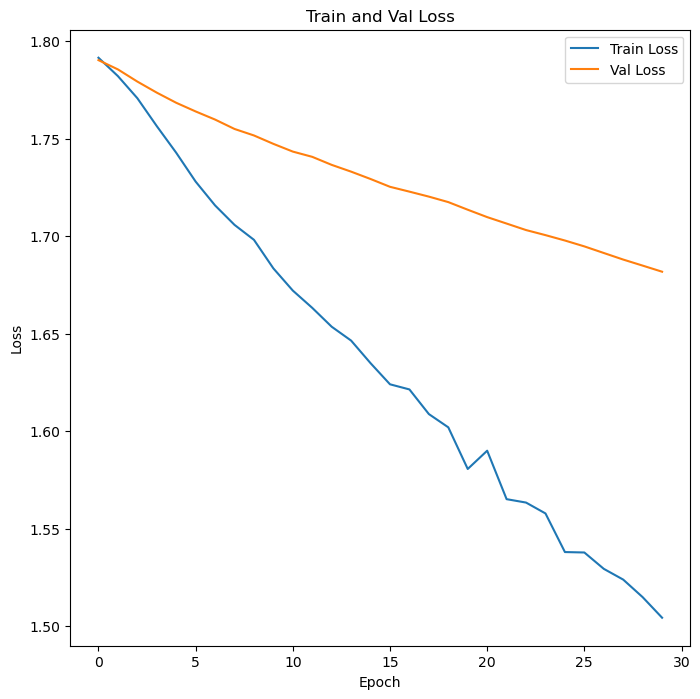

c:\Users\vishh\.conda\envs\specpart_gnn\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\vishh\.conda\envs\specpart_gnn\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\vishh\.conda\envs\specpart_gnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\vishh\.conda\envs\specpart_gnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

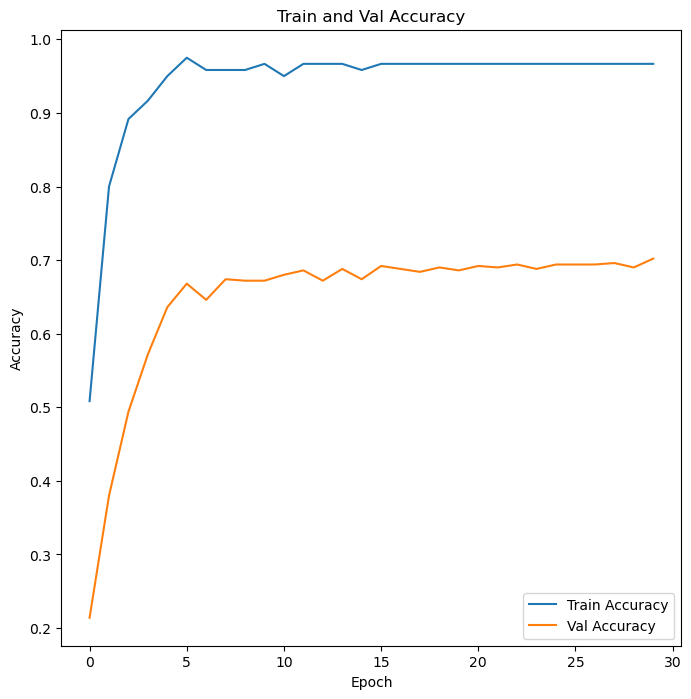

In [10]:
line_plot(adagrad_train_losses, adagrad_val_losses, 'Loss')
line_plot(adagrad_train_accuracies, adagrad_val_accuracies, 'Accuracy')

### Train with Adam

In [11]:
adam_train_losses = []
adam_train_accuracies = []
adam_val_losses = []
adam_val_accuracies = []

for epoch in range(0, 50):
    train_loss, train_acc = train(adam_model, adam_optim)
    adam_train_losses.append(train_loss)
    adam_train_accuracies.append(train_acc)

    val_loss, val_acc = eval(adam_model)
    adam_val_losses.append(val_loss)
    adam_val_accuracies.append(val_acc)
    print(f'Epoch: {epoch:03d} -> Train Loss: {train_loss:.6f} Train Acc: {train_acc * 100:.2f}% Val Loss: {val_loss:.6f} Val Acc: {val_acc * 100:.2f}%')

torch.Size([3327, 6])
Epoch: 000 -> Train Loss: 1.791531 Train Acc: 30.00% Val Loss: 1.790452 Val Acc: 8.40%
torch.Size([3327, 6])
Epoch: 001 -> Train Loss: 1.784986 Train Acc: 67.50% Val Loss: 1.787291 Val Acc: 33.40%
torch.Size([3327, 6])
Epoch: 002 -> Train Loss: 1.777638 Train Acc: 82.50% Val Loss: 1.783666 Val Acc: 45.80%
torch.Size([3327, 6])
Epoch: 003 -> Train Loss: 1.767916 Train Acc: 81.67% Val Loss: 1.780246 Val Acc: 43.40%
torch.Size([3327, 6])
Epoch: 004 -> Train Loss: 1.756866 Train Acc: 85.83% Val Loss: 1.776494 Val Acc: 46.40%
torch.Size([3327, 6])
Epoch: 005 -> Train Loss: 1.742131 Train Acc: 85.83% Val Loss: 1.771752 Val Acc: 51.80%
torch.Size([3327, 6])
Epoch: 006 -> Train Loss: 1.731127 Train Acc: 88.33% Val Loss: 1.766605 Val Acc: 54.40%
torch.Size([3327, 6])
Epoch: 007 -> Train Loss: 1.721801 Train Acc: 89.17% Val Loss: 1.760919 Val Acc: 54.20%
torch.Size([3327, 6])
Epoch: 008 -> Train Loss: 1.706298 Train Acc: 89.17% Val Loss: 1.754135 Val Acc: 57.80%
torch.Size(

In [12]:
adam_test_acc = test(adam_model, data.test_mask)
print(f"Adam Test Accuracy: {adam_test_acc*100}%")

Adam Test Accuracy: 70.8%


c:\Users\vishh\.conda\envs\specpart_gnn\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\vishh\.conda\envs\specpart_gnn\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\vishh\.conda\envs\specpart_gnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\vishh\.conda\envs\specpart_gnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

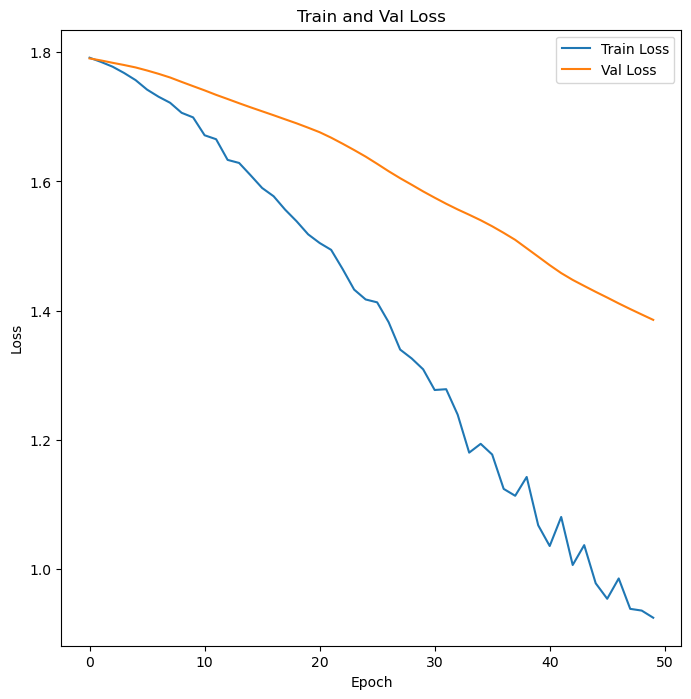

c:\Users\vishh\.conda\envs\specpart_gnn\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\vishh\.conda\envs\specpart_gnn\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\vishh\.conda\envs\specpart_gnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\vishh\.conda\envs\specpart_gnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

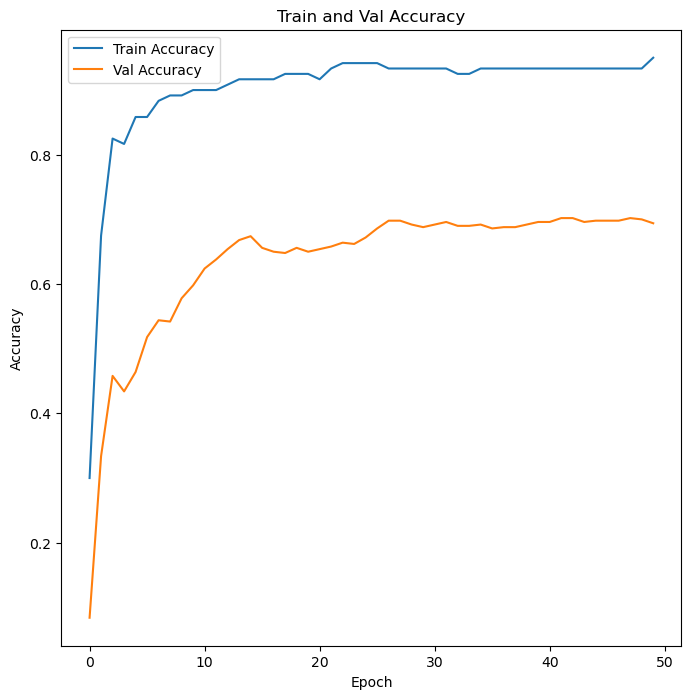

In [13]:
line_plot(adam_train_losses, adam_val_losses, 'Loss')
line_plot(adam_train_accuracies, adam_val_accuracies, 'Accuracy')

c:\Users\vishh\.conda\envs\specpart_gnn\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\vishh\.conda\envs\specpart_gnn\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\vishh\.conda\envs\specpart_gnn\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Users\vishh\.conda\envs\specpart_gnn\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, 

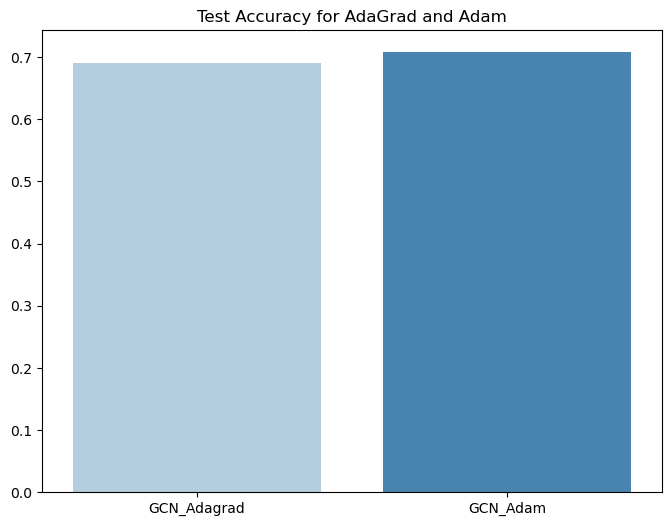

c:\Users\vishh\.conda\envs\specpart_gnn\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\vishh\.conda\envs\specpart_gnn\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\vishh\.conda\envs\specpart_gnn\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Users\vishh\.conda\envs\specpart_gnn\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, 

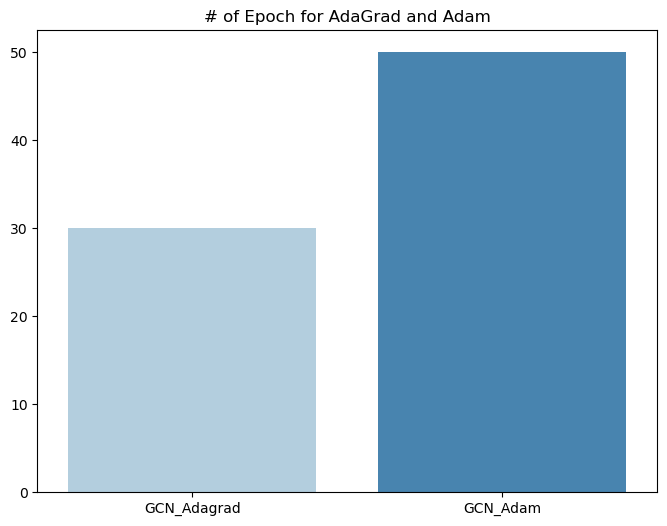

In [14]:
bar_plot(adagrad_test_acc, adam_test_acc, 'Accuracy', 'Test Accuracy for AdaGrad and Adam')
bar_plot(30, 50, 'Epoch', '# of Epoch for AdaGrad and Adam')